In [1]:
import os
import modred as mr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

def perform_POD(data: xr.Dataset, var_name: str, num_modes: int):
    print(f"Percentage of NaN values: {int(100*np.isnan(data[var_name]).sum()/np.prod(data[var_name].shape))}%")
    data = data[var_name].squeeze()
    print(f"Data dims: {data.dims}, data shape: {data.values.shape}")
    data = data.values
    orig_data_shape = data.shape

    # reshape data (flattened snapshots vs time -> 2d array)
    data = data.reshape(data.shape[0], -1).T
    print(f"Shape of input data: {data.shape} [flattened space x time snapshots]")

    # compute POD: https://modred.readthedocs.io/en/stable/pod.html#modred.pod.compute_POD_arrays_snaps_method
    POD_res = mr.compute_POD_arrays_snaps_method(data, list(mr.range(num_modes)))
    # POD_res = mr.compute_POD_arrays_direct_method(data, list(mr.range(num_modes)))
    assert POD_res.eigvals.all() == np.array(sorted(POD_res.eigvals)).all(), "Eigenvalues not sorted"

    return POD_res.modes, POD_res.eigvals, POD_res.proj_coeffs, data, orig_data_shape

Percentage of NaN values: 0%
Data dims: ('time', 'latitude', 'longitude'), data shape: (228, 85, 121)
Shape of input data: (10285, 228) [flattened space x time snapshots]
(10285, 228)


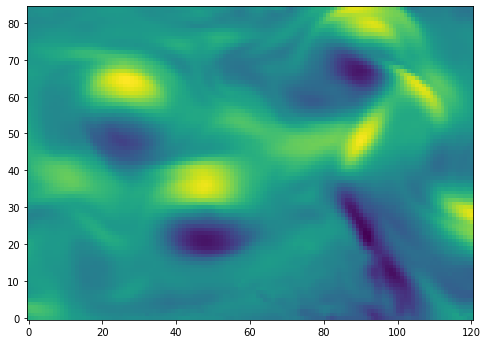

In [1]:
# set area
area="GoM"
if area == "area1":
    # Area 1
    data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/area1"
    files = os.listdir(data_dir)
    data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-140, -120), latitude=slice(15,32))
elif area == "GoM":
    # GoM
    data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/GoM"
    files = os.listdir(data_dir)
    data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-95, -85), latitude=slice(22,29))
else:
    print("Area name is invalid!")
    data = None

modes, eigvals, proj_coeffs, data, orig_data_shape = perform_POD(data, "utotal", 6)

# plot one snapshot
fig = plt.figure(figsize=(8, 8))
print(data.shape)
plt.imshow(data[:, 0].reshape(orig_data_shape[1:]), origin="lower")

In [126]:
# save all frames of original data to make gif
for i in range(data.shape[1]):
    plt.imsave(f"/home/jonas/Downloads/plots/data_gif/{str(i).zfill(4)}.png", data[:, i].reshape(orig_data_shape[1:]), origin="lower")

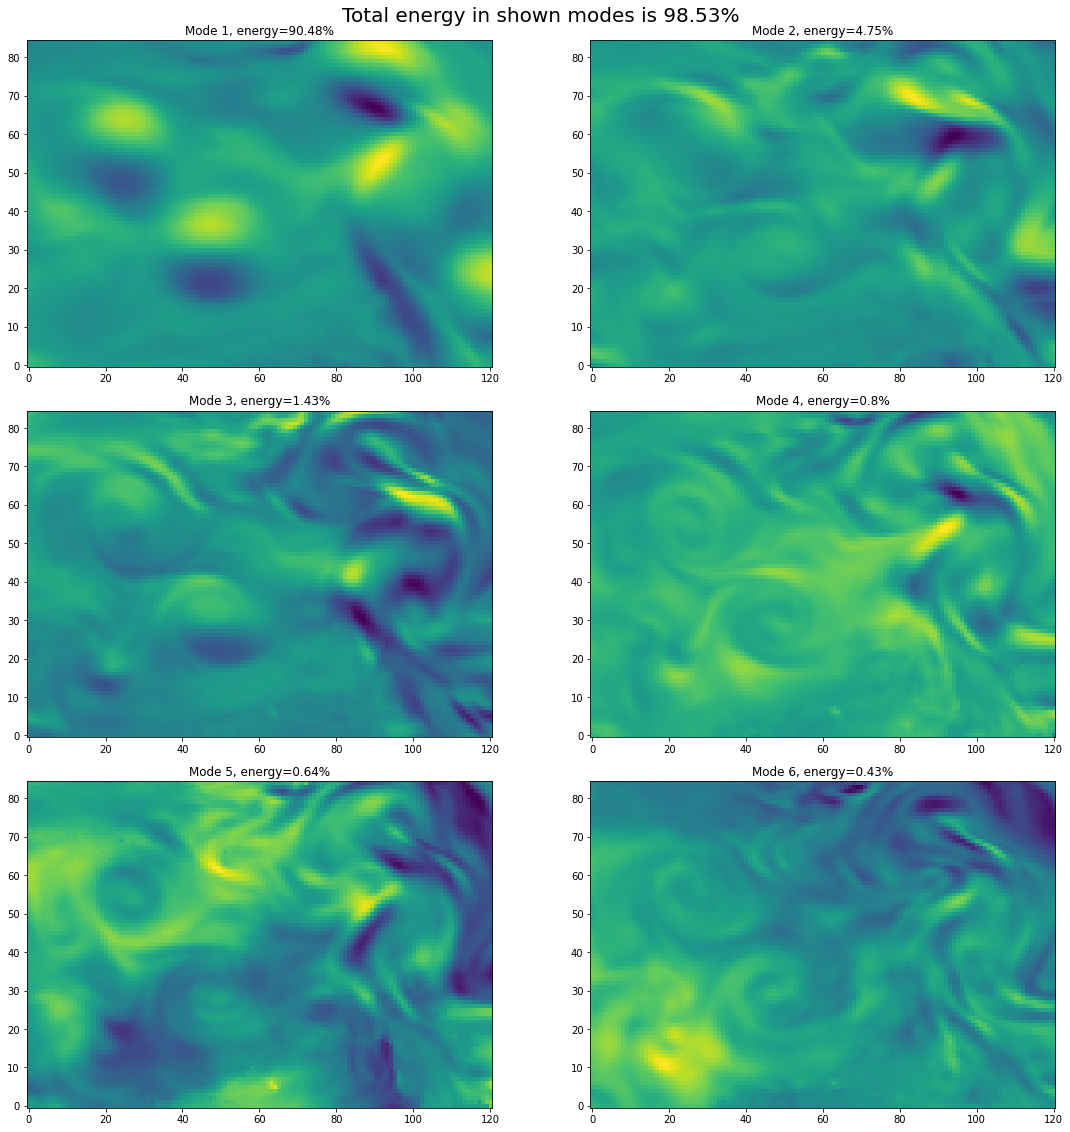

In [2]:
sum_eigvals = eigvals.sum()
normalized_eigvals = eigvals/sum_eigvals

fig, axs = plt.subplots(int(modes.shape[1]/2), 2, figsize=(16, 16))
for i in range(modes.shape[1]):
    ax = axs[int(i//2), i%2]
    ax.imshow(modes[:, i].reshape(orig_data_shape[1:]), origin="lower")
    ax.set_title(f"Mode {i+1}, energy={round(normalized_eigvals[i]*100, 2)}%")
fig.suptitle(f"Total energy in shown modes is {round(normalized_eigvals[:modes.shape[1]].sum()*100, 2)}%", fontsize=20)
plt.tight_layout()
plt.show()

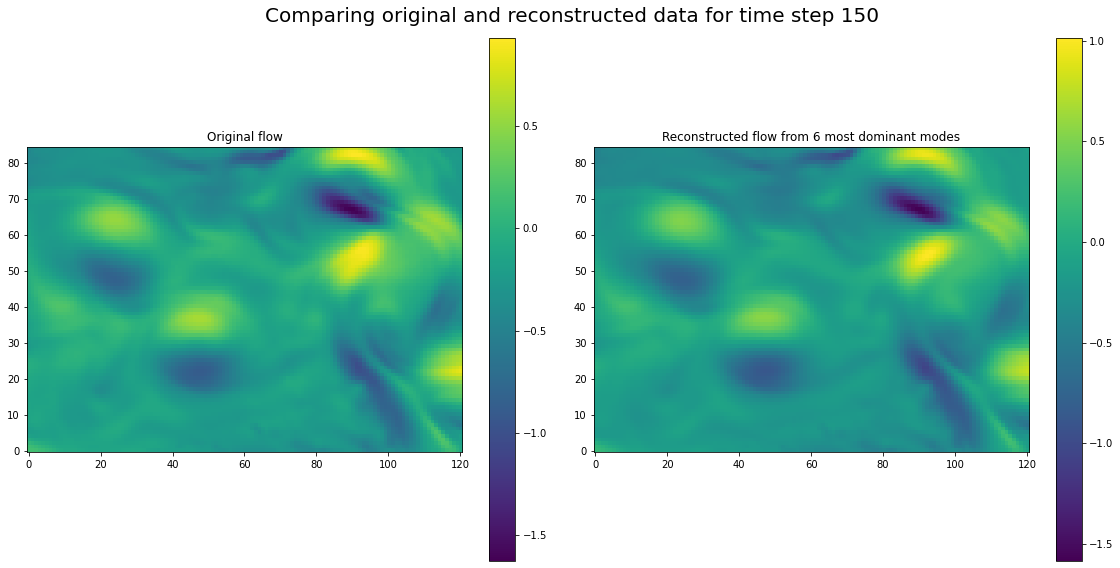

In [3]:
time_step = 150

fig, axs = plt.subplots(1, 2, figsize=(16,8))
img1 = axs[0].imshow(data[:, time_step].reshape(orig_data_shape[1:]), origin="lower")
axs[0].set_title("Original flow")
plt.colorbar(img1, ax=axs[0])

# proj coeffs are of shape [mode x time] -> whole column for first time step
reconstructed_currents = np.zeros_like(modes[:, 0])
for i in range(modes.shape[1]):
    scaling = proj_coeffs[i, time_step]
    reconstructed_currents += modes[:, i] * scaling

img2 = axs[1].imshow(reconstructed_currents.reshape(orig_data_shape[1:]), origin="lower")
axs[1].set_title("Reconstructed flow from 6 most dominant modes")
plt.colorbar(img2, ax=axs[1])

fig.suptitle(f"Comparing original and reconstructed data for time step {time_step}", fontsize=20)
plt.tight_layout()
plt.show()

## Try compressed sensing with forecast first

##### Compressed sensing optimization

$$ \min_s || C\Psi s - y ||_2 + \lambda ||s||_1 $$

$$ x = \Psi s $$

where C is the sampling matrix and Psi is the linear transformation that maps from the sample domain to the domain the original signal can be represented in sparsely.

Percentage of NaN values: 0%
Data dims: ('time', 'latitude', 'longitude'), data shape: (228, 121, 241)
Shape of input data: (29161, 228) [flattened space x time snapshots]
Number of modes used: 228.
Number of measurements: 29.


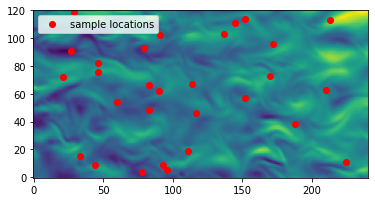

In [84]:
import cvxpy as cvx

# load forecast data for area 1
data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/area1"
files = os.listdir(data_dir)
data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-140, -120), latitude=slice(20,30))

# get most dominant modes
num_modes = orig_data_shape[0]
modes, eigvals, proj_coeffs, data, orig_data_shape = perform_POD(data, "utotal", num_modes=num_modes)
print(f"Number of modes used: {num_modes}.")

# sample from forecast frame
fc_frame = data[:, 0].reshape(orig_data_shape[1:])

# sample from fc frame and get sample vector y
num_samples = int(0.001 * np.prod(fc_frame.shape))
print(f"Number of measurements: {num_samples}.")
samples_idx = np.random.choice(np.prod(fc_frame.shape), num_samples, replace=False)
y = fc_frame.flat[samples_idx]

# plot fc frame and samples
plt.imshow(fc_frame, origin="lower")
plt.scatter(samples_idx%orig_data_shape[2], samples_idx//orig_data_shape[2], color="r", label="sample locations")
plt.legend()
plt.show()

# Set Psi
Psi = modes

# setup C
C = np.zeros((num_samples, np.prod(fc_frame.shape)))
one_indices = np.array([[row, col] for row, col in zip(range(num_samples), samples_idx)])
C[one_indices[:, 0], one_indices[:, 1]] = 1

# construct A matrix
A = C @ Psi

# perform CS
vx = cvx.Variable(A.shape[-1])
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A @ vx == y]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=False)
basis_coeffs = np.array(vx.value)

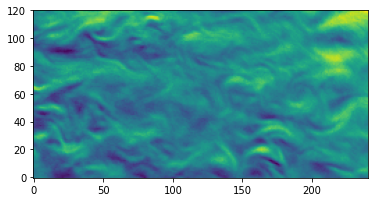

In [85]:
reconstructed_fc = np.dot(Psi, basis_coeffs)
reconstructed_fc = reconstructed_fc.reshape(orig_data_shape[1:])
plt.imshow(reconstructed_fc, origin="lower")
plt.show()

In [89]:
# compute RMSE between real and reconstructed
error = fc_frame.reshape(orig_data_shape[1:]) - reconstructed_fc
rmse = np.sqrt((error**2).mean())
print(f"RMSE: {round(rmse, 4)}.")

RMSE: 0.0404.


## Try compressed sensing with a few basis vectors

In [14]:
# load forecast data for area 1
data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/area1"
files = os.listdir(data_dir)
data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-140, -120), latitude=slice(10,20))

# get most dominant modes
modes, eigvals, proj_coeffs, data, orig_data_shape = perform_POD(data, "utotal", 6)

Percentage of NaN values: 0%
Data dims: ('time', 'latitude', 'longitude'), data shape: (228, 61, 241)
Shape of input data: (14701, 228) [flattened space x time snapshots]


In [24]:
from ocean_navigation_simulator.generative_error_model.Dataset import Dataset

# load buoy-forecast error for area 1
dataset = Dataset("data/drifter_data", "forecast", "area1")
sparse_data = dataset.load_dataset()

# create hours column
sparse_data["hour"] = sparse_data["time"].apply(lambda x: x[:13])
hours = sorted(set(sparse_data["hour"].tolist()))
sparse_data_time_step = sparse_data[sparse_data["hour"] == hours[0]]
print(f"Number of points for time step: {sparse_data_time_step.shape[0]}.")
print(f"Leads to a non-zero element percentage of {round(100*sparse_data_time_step.shape[0]/(20*12 * 10*12), 4)}%.")

Loaded area1 from forecasts.
Number of points for time step: 26.
Leads to a non-zero element percentage of 0.0903%.


In [ ]:
# use modes as basis matrix Psi
Psi = modes

# create the C matrix. Zero where there are no measurements and 1 where there exists a measurement
# need to interpolate buoy positions to grid
